# Blood Lactate prediction for cycling - Research & Model Building

## Import required libraries

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and read the data into a Pandas dataframe

##### Load the data from the 3 days of cycling collected

In [64]:
df1 = pd.read_csv('day1_data_WITHOUT_ARRHYTHMIAS.csv', 
                  names = ["Time","Power","VO2","Cadence","La","RF","HR","Sat"])
df2 = pd.read_csv('day2_data_WITHOUT_ARRHYTHMIAS.csv', 
                  names = ["Time","Power","VO2","Cadence","La","RF","HR","Sat"],sep = ";")
df3 = pd.read_csv('day3_data_WITHOUT_ARRHYTHMIAS.csv', 
                  names = ["Time","Power","VO2","Cadence","La","RF","HR","Sat"], sep = ";")

frames = [df1,df2,df3]

df = pd.concat(frames)


## Basic info of the data

In [58]:
#Basic information

print(df.info())
print("*************************************************************************\n")
#Describe the data

print(df.describe())
print("*************************************************************************\n")
print(f'The shape of the dataframe is {df.shape}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8818 entries, 0 to 2399
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     8818 non-null   int64  
 1   Power    8818 non-null   int64  
 2   VO2      8818 non-null   float64
 3   Cadence  8818 non-null   int64  
 4   La       8818 non-null   float64
 5   RF       8818 non-null   float64
 6   HR       8818 non-null   float64
 7   Sat      8818 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 878.1 KB
None
*************************************************************************

              Time        Power          VO2      Cadence           La  \
count  8818.000000  8818.000000  8818.000000  8818.000000  8818.000000   
mean   1495.002381   130.438195  2304.234842    75.841461     5.331533   
std     887.721781   113.460720  1013.735739    39.749343     3.215427   
min       1.000000     0.000000     2.414900     0.000000     0.580000   
25%     735.

##### there is no missing value or NAN values in any of the data sets. All the columns are numeric.

## Exploratory Data Analysis

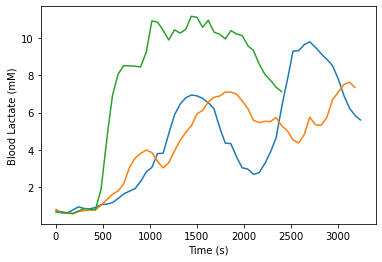

In [12]:
#Initial look at the blood lactate data from the 3 dataframes with time used as an index on the x axis

for i in frames:
    plt.plot(i.Time,i.La)
    plt.xlabel('Time (s)')
    plt.ylabel('Blood Lactate (mM)')

In [5]:
df.corr()

,Time,Power,VO2,Cadence,La,RF,HR,Sat
Time,1.000000,-0.046681,0.049032,-0.110181,0.580773,0.297472,0.171947,-0.617371
Power,-0.046681,1.000000,0.602739,0.671932,-0.016983,0.379241,0.593718,0.078258
VO2,0.049032,0.602739,1.000000,0.693714,0.209067,0.778697,0.938484,0.020588
Cadence,-0.110181,0.671932,0.693714,1.000000,-0.031408,0.462451,0.663975,0.138539
La,0.580773,-0.016983,0.209067,-0.031408,1.000000,0.491533,0.252437,-0.405162
RF,0.297472,0.379241,0.778697,0.462451,0.491533,1.000000,0.745110,-0.165612
HR,0.171947,0.593718,0.938484,0.663975,0.252437,0.745110,1.000000,0.005782
Sat,-0.617371,0.078258,0.020588,0.138539,-0.405162,-0.165612,0.005782,1.000000


As we have established that blood lactate acts in an exponential way, the correlation matrix does not reveal strong linear relationships with the other variables. Despite this it does have a moderate correlation with respiratory frequency (RF) and Time.
Try log transformation of La to see if relationship changes with other variables.

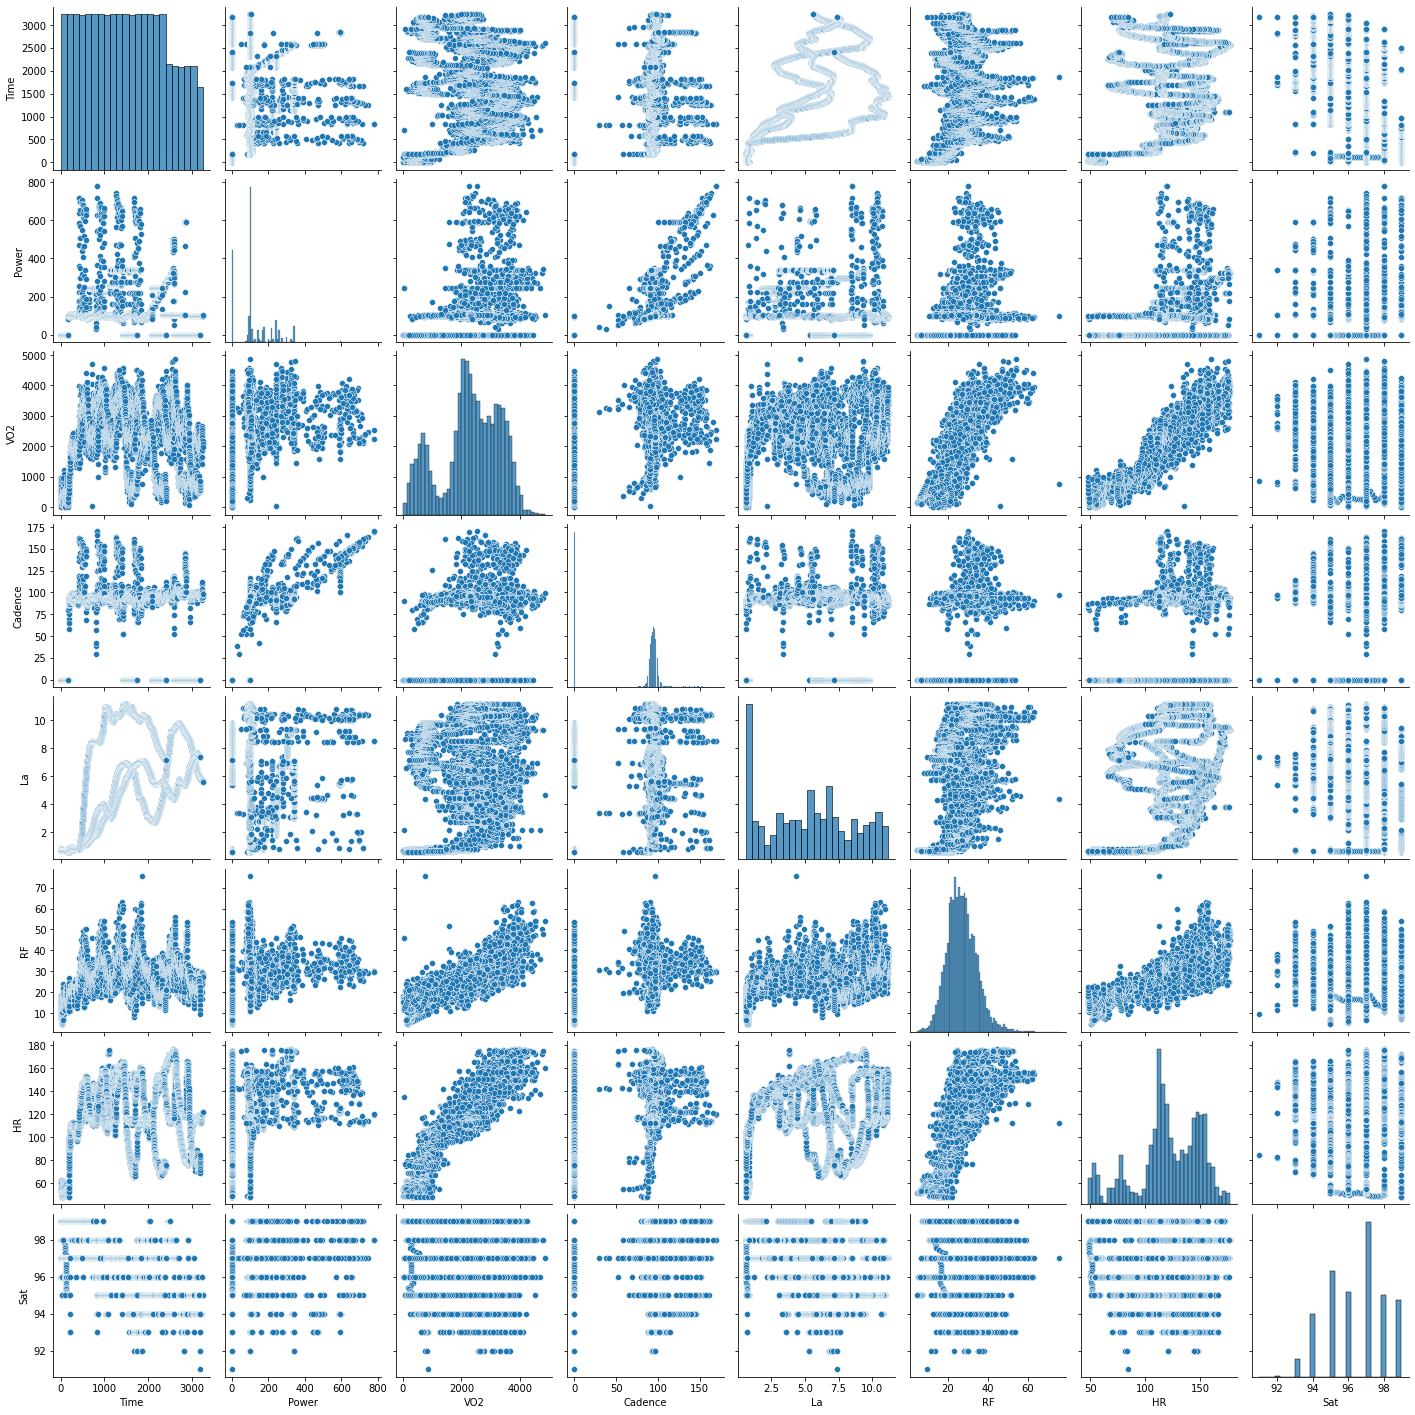

In [50]:
# Pairwise scatter plot between any two features
sns.pairplot(df)
plt.show()

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


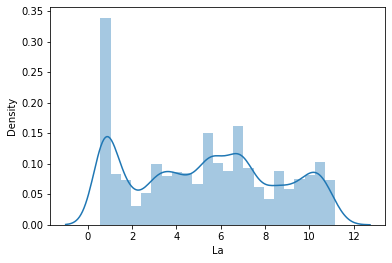

In [7]:
# Plotting Blood lactate - target variable for the dataset

sns.distplot(df.La)
plt.show()

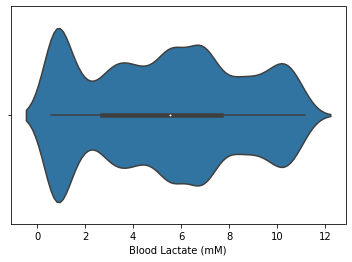

In [49]:
# Violin plot showing the spread of blood lactate datapoints and density fluctuations

sns.violinplot(x=df.La)
plt.xlabel('Blood Lactate (mM)')
plt.show()

Text(0, 0.5, 'Resp Frequency (RF)')

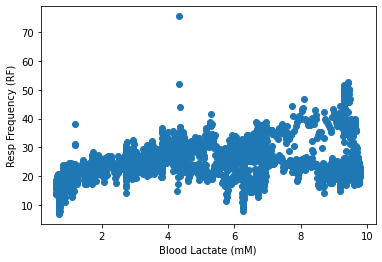

In [25]:
# Exploring correlation of RF and Blood lactate

plt.scatter(df1.La,df1.RF)
plt.xlabel('Blood Lactate (mM)')
plt.ylabel('Resp Frequency (RF)')

## Preparing Data for modelling

#### Assigning Blood lactate as the target variable and also dropping Saturation as this isn't a metric able to be collected without additional equipment.

#### Data is separated into a train/test split with 80% training data and 20% test data

In [65]:
x = df.drop(["La","Sat"], axis = 1)
y = df['La']

trainX, testX, trainY, testY = train_test_split(x,y, test_size = 0.2)

#### Some models are better suited to normalised data so we prepare the scaled train and test data for models that require them

In [66]:
sc = StandardScaler()

scaler = sc.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)

# Model - Gradient Boosting Regressor

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [68]:
#Setting initial hyperparameters for model
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01
}

In [69]:
#Building the Gradient Boosting Regressor model with set hyperparameters
reg = ensemble.GradientBoostingRegressor(**params,random_state=25)

#Fit the model with training data
reg.fit(trainX, trainY)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500, random_state=25)

In [70]:
#Evaluate model with test data
y_pred = reg.predict(testX)
r2_score(testY, y_pred)

0.9362641578999832

In [71]:
#Dataframe created of predicted values compared to actual values of blood lactate
df_temp = pd.DataFrame({'Actual': testY, 'Predicted': y_pred})
df_temp.head()

,Actual,Predicted
1880,10.3270,10.152489
880,2.1865,2.764035
1413,10.8570,10.173828
2683,5.5067,5.292957
451,1.0053,1.071722


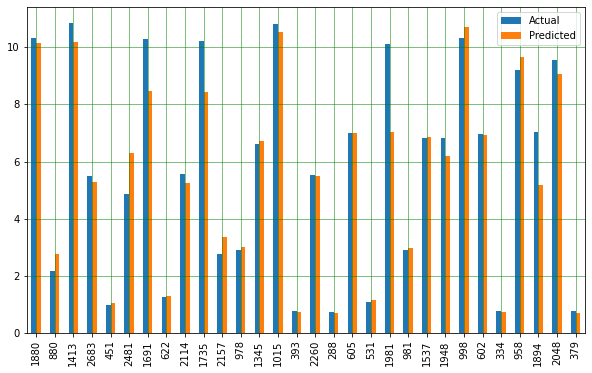

In [72]:
#Visualising the comparison
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

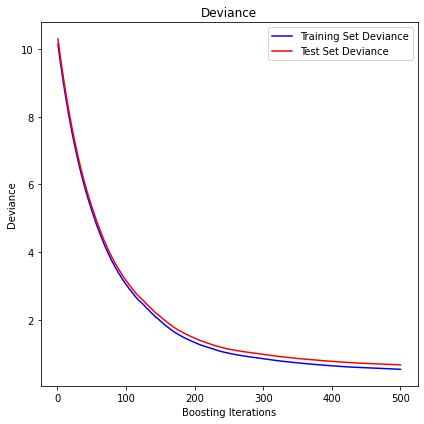

In [74]:
#Visualising change in deviance in training and testing data for n boosting iterations

test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(testX)):
    test_score[i] = reg.loss_(testY, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

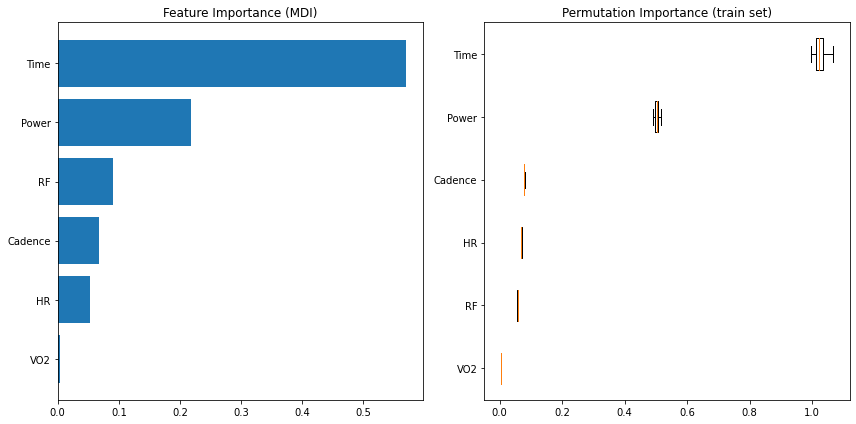

In [78]:
#Analysing feature importance from dataset using 2 methods 
    #feature importance using MDI (Mean Decrease in Impurity) 
    #feature importance using permutation

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(x.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, trainX, trainY, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(x.columns)[sorted_idx],
)
plt.title("Permutation Importance (train set)")
fig.tight_layout()
plt.show()

As we can see in the figures above, VO2 interestingly is not being shown as an important feature for predicting blood lactate, with a value of near zero on both methods of checking. As VO2 is usually a difficult metric to collect this is positive news for constructing the prediction model as all other features are metrics that can be easily collected with inexpensive equipment.

In [90]:
# VO2 is dropped from the feature set after providing near no value to the model accuracy

x = df.drop(['VO2',"La","Sat"], axis = 1)
y = df['La']

trainX, testX, trainY, testY = train_test_split(x,y, test_size = 0.2)

In [106]:
#Tuning the hyperparameters of the model to build the best fitting model possible
reg = ensemble.GradientBoostingRegressor(random_state=25)
gridsearch = GridSearchCV(estimator=reg,
                          param_grid={
                              'n_estimators': [10,50, 100, 250, 500],
                              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                              'subsample' : [0.5,0.7,1],
                              'max_depth' : [3,7,9]
                          },
                          cv= 5,
                          return_train_score=False,
                          scoring='r2')
gridsearch.fit(trainX, trainY)
pd.DataFrame(gridsearch.cv_results_).set_index('rank_test_score').sort_index()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,
1,5.826109,0.007870,0.036635,0.000799,0.1,9,500,0.7,"{'learning_rate': 0.1, 'max_depth': 9, 'n_esti...",0.993985,0.991902,0.987784,0.989095,0.988427,0.990238,0.002342
2,2.904748,0.010918,0.020213,0.000403,0.1,9,250,0.7,"{'learning_rate': 0.1, 'max_depth': 9, 'n_esti...",0.993972,0.991890,0.987738,0.989058,0.988397,0.990211,0.002354
3,3.522817,0.021598,0.027824,0.000743,0.1,7,500,0.5,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.991608,0.989761,0.990901,0.989917,0.988120,0.990061,0.001181
4,1.145038,0.001897,0.010415,0.000490,0.1,9,100,0.7,"{'learning_rate': 0.1, 'max_depth': 9, 'n_esti...",0.993907,0.991770,0.987533,0.988920,0.988155,0.990057,0.002410
5,4.253876,0.005503,0.052648,0.000487,0.01,9,500,0.5,"{'learning_rate': 0.01, 'max_depth': 9, 'n_est...",0.993299,0.991849,0.987779,0.989279,0.987555,0.989952,0.002268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,0.092877,0.002136,0.002009,0.000003,0.0001,7,10,0.7,"{'learning_rate': 0.0001, 'max_depth': 7, 'n_e...",0.001190,0.001770,0.000384,0.001582,-0.000869,0.000811,0.000965
222,0.070467,0.000493,0.002402,0.000485,0.0001,7,10,0.5,"{'learning_rate': 0.0001, 'max_depth': 7, 'n_e...",0.001183,0.001777,0.000379,0.001579,-0.000870,0.000810,0.000967
223,0.058455,0.000489,0.002202,0.000401,0.0001,3,10,1,"{'learning_rate': 0.0001, 'max_depth': 3, 'n_e...",0.000803,0.001325,-0.000027,0.001164,-0.001285,0.000396,0.000962


If we look at the mean accuracy for the cross validation, the best ranked model performs at 99.02% accuracy which is a strong model.

In [108]:
# Best hyperparameters are displayed
print(gridsearch.best_params_)

{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.7}


In [109]:
params = {
    'learning_rate': 0.1, 
    'max_depth': 9,
    'n_estimators': 500,
    'subsample': 0.7}
#or params = gridsearch.best_params_ 
#gives parameters from the trained cross validation

In [147]:
#Model is built with new hyperparameters
GBRmodel = ensemble.GradientBoostingRegressor(**params,random_state=25)
GBRmodel.fit(trainX,trainY)
GBRtestY_predict = GBRmodel.predict(testX)

In [148]:
#Prediction accuracy is given for the model built with r2_score of the 5 variables
r2_score(testY, GBRtestY_predict)

0.9946433172895832

On the unseen test data the GBR model performs equally well as predicted. This is an improvement after hyperparameter tuning as the accuracy increased from 94.72% to 99.46% when testing again.

Text(0, 0.5, 'testY_predict')

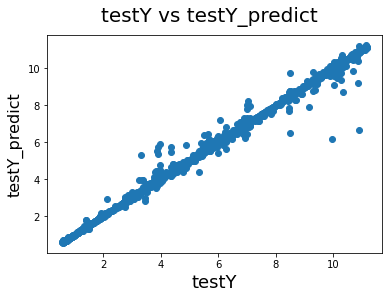

In [149]:
#Visualising the prediction of blood lactate with scatterplot, showing the spread of data

fig = plt.figure()
plt.scatter(testY, GBRtestY_predict)
fig.suptitle('testY vs testY_predict', fontsize = 20)              # Plot heading 
plt.xlabel('testY', fontsize = 18)                                 # X-label
plt.ylabel('testY_predict', fontsize = 16)  

# Model 2 MLP Regressor

In [127]:
x = df.drop(["VO2","La","Sat"], axis = 1)
y = df['La']

trainX, testX, trainY, testY = train_test_split(x,y, test_size = 0.2)

In [128]:
sc = StandardScaler()

scaler = sc.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)

In [129]:
mlp_reg = MLPRegressor(alpha = 0.0001,hidden_layer_sizes=(150,100,50), 
                       learning_rate= 'adaptive', max_iter= 300, solver='adam', activation = 'relu')
mlp_reg.fit(trainX_scaled, trainY)

MLPRegressor(hidden_layer_sizes=(150, 100, 50), learning_rate='adaptive',
             max_iter=300)

In [130]:
y_pred = mlp_reg.predict(testX_scaled)

In [131]:
from sklearn.metrics import r2_score
r2_score(testY, y_pred)

0.9710165119756428

In [132]:
scores = cross_val_score(mlp_reg, trainX_scaled, trainY, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.96 accuracy with a standard deviation of 0.01


At a base line for the MLP Regressor Model we get a cross validated accuracy of 96%

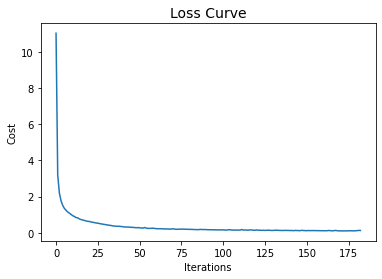

In [133]:
# Visualize the loss factor

plt.plot(mlp_reg.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

Need to conduct hyperparameter tuning to try and improve model. Also need to try other models.

In [134]:
mlp_reg = MLPRegressor()


In [ ]:
# Display the best parameters & build the best fit model with these parameters

MLPgrid = GridSearchCV(mlp_reg, param_grid, n_jobs= -1, cv=5)
MLPgrid.fit(trainX_scaled, trainY)

print(MLPgrid.best_params_) 

In [138]:
MLPgridsearch = GridSearchCV(estimator=MLPRegressor(),
                             param_grid = {
                                 'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
                                 'max_iter': [100,300, 500],
                                 'activation': ['tanh', 'relu'],
                                 'solver': ['sgd', 'adam'],
                                 'alpha': [0.0001, 0.05],
                                 'learning_rate': ['constant','adaptive']
                             },
                          cv=5,
                          return_train_score=False,
                          scoring='r2')
MLPgridsearch.fit(trainX_scaled, trainY)
pd.DataFrame(MLPgridsearch.cv_results_).set_index('rank_test_score').sort_index()

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,
1,33.488479,6.730909,0.011210,0.000400,tanh,0.0001,"(150, 100, 50)",adaptive,500,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.973586,0.979893,0.973298,0.983796,0.979255,0.977965,0.004009
2,36.258600,10.086242,0.011410,0.000491,tanh,0.0001,"(150, 100, 50)",constant,500,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.966875,0.976991,0.980316,0.981125,0.981086,0.977279,0.005419
3,30.823253,6.304823,0.008808,0.000400,tanh,0.0001,"(120, 80, 40)",adaptive,500,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.977056,0.982286,0.970692,0.974774,0.976857,0.976333,0.003755
4,30.109003,1.236406,0.011210,0.000400,tanh,0.0001,"(150, 100, 50)",adaptive,300,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.971372,0.979056,0.979104,0.975219,0.972983,0.975547,0.003133
5,27.549274,1.455991,0.007407,0.000490,tanh,0.0001,"(100, 50, 30)",adaptive,500,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.969480,0.979721,0.975470,0.979358,0.973681,0.975542,0.003801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,7.092448,0.009129,0.007212,0.000403,tanh,0.05,"(120, 80, 40)",constant,100,sgd,"{'activation': 'tanh', 'alpha': 0.05, 'hidden_...",0.837794,0.848136,0.818059,0.826654,0.815077,0.829144,0.012349
141,6.059715,0.019319,0.006206,0.000400,tanh,0.0001,"(100, 50, 30)",adaptive,100,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.834442,0.851787,0.818760,0.826903,0.813489,0.829076,0.013406
142,7.000772,0.007290,0.007607,0.000491,tanh,0.0001,"(120, 80, 40)",adaptive,100,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.832200,0.846617,0.820385,0.824110,0.820943,0.828851,0.009834


In [139]:
MLPmodel = MLPgridsearch.best_estimator_

In [141]:
print(MLPmodel)

MLPRegressor(activation='tanh', hidden_layer_sizes=(150, 100, 50),
             learning_rate='adaptive', max_iter=500)


In [142]:
MLPmodel = MLPRegressor(activation='tanh', hidden_layer_sizes=(150, 100, 50),
             learning_rate='adaptive', max_iter=500)

In [143]:
MLPmodel.fit(trainX_scaled,trainY)
MLPtestY_predict = MLPmodel.predict(testX_scaled)

In [144]:
r2_score(testY, MLPtestY_predict)

0.987896403935139

Text(0, 0.5, 'testY_predict')

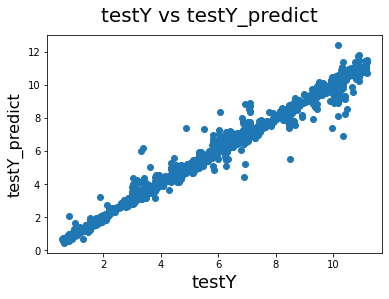

In [145]:
fig = plt.figure()
plt.scatter(testY, MLPtestY_predict)
fig.suptitle('testY vs testY_predict', fontsize = 20)              # Plot heading 
plt.xlabel('testY', fontsize = 18)                                 # X-label
plt.ylabel('testY_predict', fontsize = 16)  

# Model 3 - Random Forest Regressor

In [52]:
gridsearch = GridSearchCV(estimator=RandomForestRegressor(),
                          param_grid={
                              'n_estimators': [50, 100, 250, 300],
                              'max_depth': [None, 100, 200, 300, 400]
                          },
                          cv=3,
                          return_train_score=False,
                          scoring='r2')
gridsearch.fit(trainX_scaled, trainY)
pd.DataFrame(gridsearch.cv_results_).set_index('rank_test_score').sort_index()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,
1,1.553094,0.009866,0.047373,4.677738e-04,400,100,"{'max_depth': 400, 'n_estimators': 100}",0.981835,0.980788,0.986253,0.982959,0.002368
2,1.608464,0.036539,0.052714,4.501211e-03,100,100,"{'max_depth': 100, 'n_estimators': 100}",0.981544,0.981159,0.986171,0.982958,0.002278
3,4.707618,0.052978,0.140133,1.631027e-03,300,300,"{'max_depth': 300, 'n_estimators': 300}",0.980516,0.982323,0.985903,0.982914,0.002239
4,3.910890,0.004994,0.118108,8.174107e-04,400,250,"{'max_depth': 400, 'n_estimators': 250}",0.980821,0.981724,0.985965,0.982837,0.002242
5,3.941090,0.021099,0.119775,9.434713e-04,200,250,"{'max_depth': 200, 'n_estimators': 250}",0.980002,0.981943,0.986507,0.982818,0.002727
6,0.785885,0.000621,0.024689,9.438084e-04,300,50,"{'max_depth': 300, 'n_estimators': 50}",0.980160,0.982259,0.985982,0.982801,0.002407
7,0.768366,0.004497,0.024025,4.215809e-06,None,50,"{'max_depth': None, 'n_estimators': 50}",0.981829,0.981835,0.984617,0.982760,0.001313
8,4.677921,0.036270,0.139794,2.359212e-03,None,300,"{'max_depth': None, 'n_estimators': 300}",0.979691,0.982350,0.986207,0.982749,0.002675
9,4.793034,0.045477,0.144131,1.634919e-03,100,300,"{'max_depth': 100, 'n_estimators': 300}",0.980755,0.981780,0.985640,0.982725,0.002103


In [53]:
print(gridsearch.best_params_)

{'max_depth': 400, 'n_estimators': 100}


In [65]:
RFmodel = RandomForestRegressor(max_depth=400, n_estimators= 100)
# or RFmodel = gridsearch.best_estimator_

In [66]:
RFmodel

RandomForestRegressor(max_depth=400)

In [71]:
RFmodel.fit(trainX_scaled,trainY)
testY_predict = RFmodel.predict(testX_scaled)

In [73]:
r2_score(testY, testY_predict)

0.9834825630374389

Text(0, 0.5, 'testY_predict')

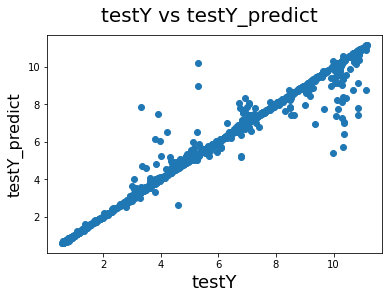

In [72]:
fig = plt.figure()
plt.scatter(testY, testY_predict)
fig.suptitle('testY vs testY_predict', fontsize = 20)              # Plot heading 
plt.xlabel('testY', fontsize = 18)                                 # X-label
plt.ylabel('testY_predict', fontsize = 16)  